# XGBoost Final Training

นำผลลัพธ์ที่ได้จากการ Grid Search มาทำการเทรนโมเดลพยากรณ์โดยใช้ข้อมูลฝึกทั้งหมด และเปรียบเทียบกับ Test set

## ตั้งค่าและนำเข้า Libraries

In [1]:

# 1. Configuaration


# System
SEED = 42

# train lenght and target dates
N_TRAIN = 618
HORIZON = 155

# Best Parameters (From Grid Search)
BEST_PARAMS = {
    'max_depth': 12,
    'learning_rate': 0.01,
    'min_child_weight': 1,
    'gamma': 0.1,
    'reg_lambda': 0.1,
    'n_estimators': 50
}
BEST_LAGS = 40

In [2]:
# 2. import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from xgboost import XGBRegressor
from skforecast.direct import ForecasterDirect

np.random.seed(SEED)
print("Libraries Loaded.")

Libraries Loaded.


## นำเข้าข้อมูล

In [3]:
# 3. LOAD DATA

sheet_id = "1-hzX_qRFjS7TIhWkTsrWPx7M_cFATCQxvWlRmo97Wac"
sheet_gid = "0"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_gid}"

data = pd.read_csv(csv_url)
if data['Date'].dtype == 'object':
    data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

y = data['Y']
y_train = y.iloc[:N_TRAIN]
y_test  = y.iloc[N_TRAIN:]

print(f"Data Split: Train={len(y_train)}, Test={len(y_test)}")

Data Split: Train=618, Test=155


## เทรนโมเดลด้วยข้อมูลฝึกทั้งหมด ด้วยกลยุทธ์ multi step directs forecasting สำหรับพยากรณ์ Test set

In [4]:
# 4. TRAIN MODEL (Test Prediction)


# Setup Model
regressor = XGBRegressor(
    **BEST_PARAMS,
    verbosity=0,
    n_jobs=-1,  # Use all cores
    random_state=SEED
)

# Setup Forecaster (Validation Set)
forecaster = ForecasterDirect(
    regressor=regressor,
    lags=BEST_LAGS,
    steps=HORIZON,  # Predict full horizon at once (Direct)
    differentiation=1,
    n_jobs=1
)

print("Fitting Final Model for Test Set")
forecaster.fit(y=y_train)
pred_test = forecaster.predict(steps=HORIZON)
print("Test Prediction Complete.")

Fitting Final Model for Test Set


/tmp/ipykernel_5388/2554325318.py:13: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster = ForecasterDirect(


Test Prediction Complete.


## เทรนโมเดลแบบ Single Step สำหรับพยากรณ์บนข้อมูลฝึกเพื่อตรวจสอบประสิทธิภาพของไฮเพอร์พารามิเตอร์เมื่อ fit เข้ากับโมเดล

In [5]:
# 5. train model


# Setup Forecaster for 1-step prediction (to check fit)
print("Fitting Model for Training Set (1-step for training set to check is model fit good)")
forecaster_train = ForecasterDirect(
    regressor=XGBRegressor(
        **BEST_PARAMS,
        verbosity=0,
        n_jobs=-1,
        random_state=SEED
    ),
    lags=BEST_LAGS,
    steps=1,  # Predict only next step
    differentiation=1,
    n_jobs=1
)
forecaster_train.fit(y=y_train)

# Rolling prediction on training data
window_size = BEST_LAGS
pred_train_list = []
pred_train_indices = []

for i in range(window_size + 1, len(y_train)):
    last_window = y_train.iloc[:i]
    pred = forecaster_train.predict(steps=1, last_window=last_window)
    pred_train_list.append(pred.iloc[0])
    pred_train_indices.append(i)
    
print("Training Reconstruction Complete.")

Fitting Model for Training Set (1-step for training set to check is model fit good)


/tmp/ipykernel_5388/1905406598.py:6: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster_train = ForecasterDirect(


Training Reconstruction Complete.


## แสดง และ บันทึกผลลัพธ์

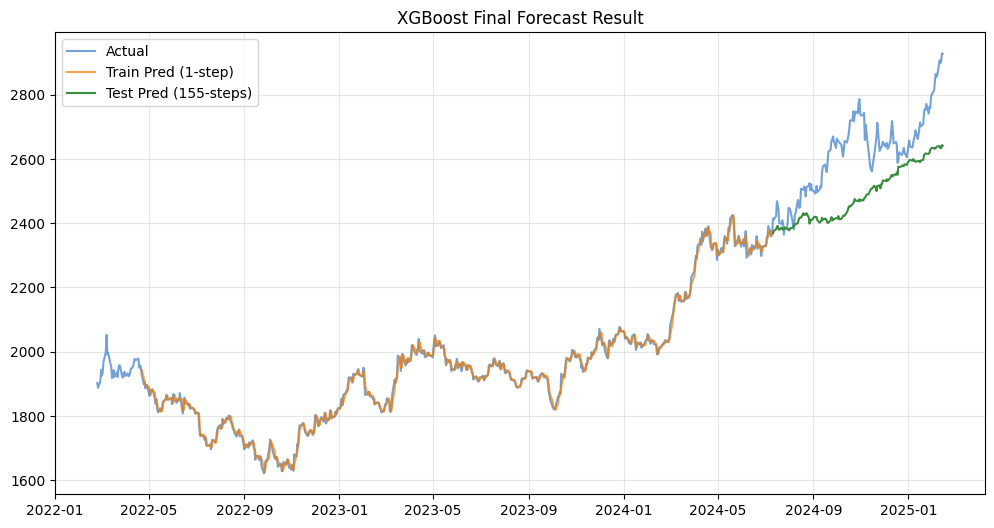

Saved to CSV file.


In [8]:
# 7. plot & save results


# Create Full DataFrame
df_final = pd.DataFrame({
    'Date': data['Date'],
    'Actual': data['Y'],
    'Train_Pred': np.nan,
    'Test_Pred': np.nan
})

# Fill Predictions
df_final.loc[pred_train_indices, 'Train_Pred'] = pred_train_list
df_final.loc[y_test.index, 'Test_Pred'] = pred_test.values

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_final['Date'], df_final['Actual'], label="Actual", color='#1565c0', alpha=0.6)
plt.plot(df_final['Date'], df_final['Train_Pred'], label="Train Pred (1-step)", color='#f57c00', alpha=0.7)
plt.plot(df_final['Date'], df_final['Test_Pred'], label=f"Test Pred ({HORIZON}-steps)", color='#388e3c')

plt.title("XGBoost Final Forecast Result")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save CSV
df_final.to_csv("XGBoost_Final_Predictions.csv", index=False)
print("Saved to CSV file.")

In [9]:
def calculate_metrics(y_true, y_pred):
    # Remove NaNs if any
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    yt = y_true[mask]
    yp = y_pred[mask]
    
    mae = np.mean(np.abs(yt - yp))
    rmse = np.sqrt(np.mean((yt - yp)**2))
    mape = np.mean(np.abs((yt - yp) / yt)) * 100
    return mae, rmse, mape

# Test Metrics
mae_test, rmse_test, mape_test = calculate_metrics(y_test.values, pred_test.values)

# Train Metrics
train_actual = y_train.iloc[pred_train_indices].values
mae_train, rmse_train, mape_train = calculate_metrics(train_actual, np.array(pred_train_list))

print("\nMetrics Summary:")
print(f"Test  -> MAD: {mae_test:.4f} RMSE: {rmse_test:.4f} MAPE: {mape_test:.4f}%")
print(f"Train -> MAD: {mae_train:.4f} RMSE: {rmse_train:.4f}  MAPE: {mape_train:.4f}%")


Metrics Summary:
Test  -> MAD: 132.5518 RMSE: 156.4902 MAPE: 4.9578%
Train -> MAD: 9.4158 RMSE: 12.2775  MAPE: 0.4827%
